In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'figure.figsize': (40, 8), 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

%load_ext autoreload
%autoreload 2

from jax_smolyak import indices, nodes
from jax_smolyak.smolyak_jax import MultivariateSmolyakBarycentricInterpolator

## Memory consumption of $F$ 

$F$ is the tensor that stores the target function evaluations and is dominating memory requirements.

### Independence of input and output dimension d (keeping the size of the multi-index set fixed at $n=5000$)

In [2]:
def size_o(indxs, k, t, d) : # original, memory-efficient implementation
    size = 0
    for nu in indxs :
        zeta = indices.smolyak_coefficient_zeta_sparse(k, t, nu=nu)
        if zeta != 0 :
            size += np.prod([si + 1 for si in nu.values()])
    return size

def size_p(indxs, k, t, d) : # using padding
    k_2_tau = {}
    k_2_n = {}
    for nu in indxs :
        zeta = indices.smolyak_coefficient_zeta_sparse(k, t, nu=nu)
        if zeta != 0 :
            tau = tuple(nu.values())
            kk = len(tau)
            k_2_tau[kk] = tuple(max(nu1, nu2) for nu1, nu2 in zip(k_2_tau.get(kk, tau), tau))
            k_2_n[kk] = k_2_n.get(kk, 0) + 1

    size = 0
    for kk in k_2_tau.keys() :
        size += np.prod([si + 1 for si in k_2_tau[kk]]) * k_2_n[kk]
    return size

def size_pp(indxs, k, t, d) : # using both permutation and padding
    k_2_tau = {}
    k_2_n = {}
    for nu in indxs :
        zeta = indices.smolyak_coefficient_zeta_sparse(k, t, nu=nu)
        if zeta != 0 :
            tau = tuple(sorted(nu.values(), reverse=True))
            kk = len(tau)
            k_2_tau[kk] = tuple(max(nu1, nu2) for nu1, nu2 in zip(k_2_tau.get(kk, tau), tau))
            k_2_n[kk] = k_2_n.get(kk, 0) + 1

    size = 0
    for kk in k_2_tau.keys() :
        size += np.prod([si + 1 for si in k_2_tau[kk]]) * k_2_n[kk]
    return size

In [3]:
d_list = [10, 20, 40, 80, 160, 320, 640, 1250, 2500]
results = np.zeros((len(d_list), 3))

n = 5000
for i, d in enumerate(d_list) :
    k = [np.log((2+j)/np.log(2)) for j in range(d)]
    node_gen = nodes.Leja(dim=d)
    t = indices.find_suitable_t(k, n, nested=node_gen.is_nested)
    indxs = indices.indexset_sparse(k, t)
    results[i] = size_o(indxs, k, t, d), size_p(indxs, k, t, d), size_pp(indxs, k, t, d)

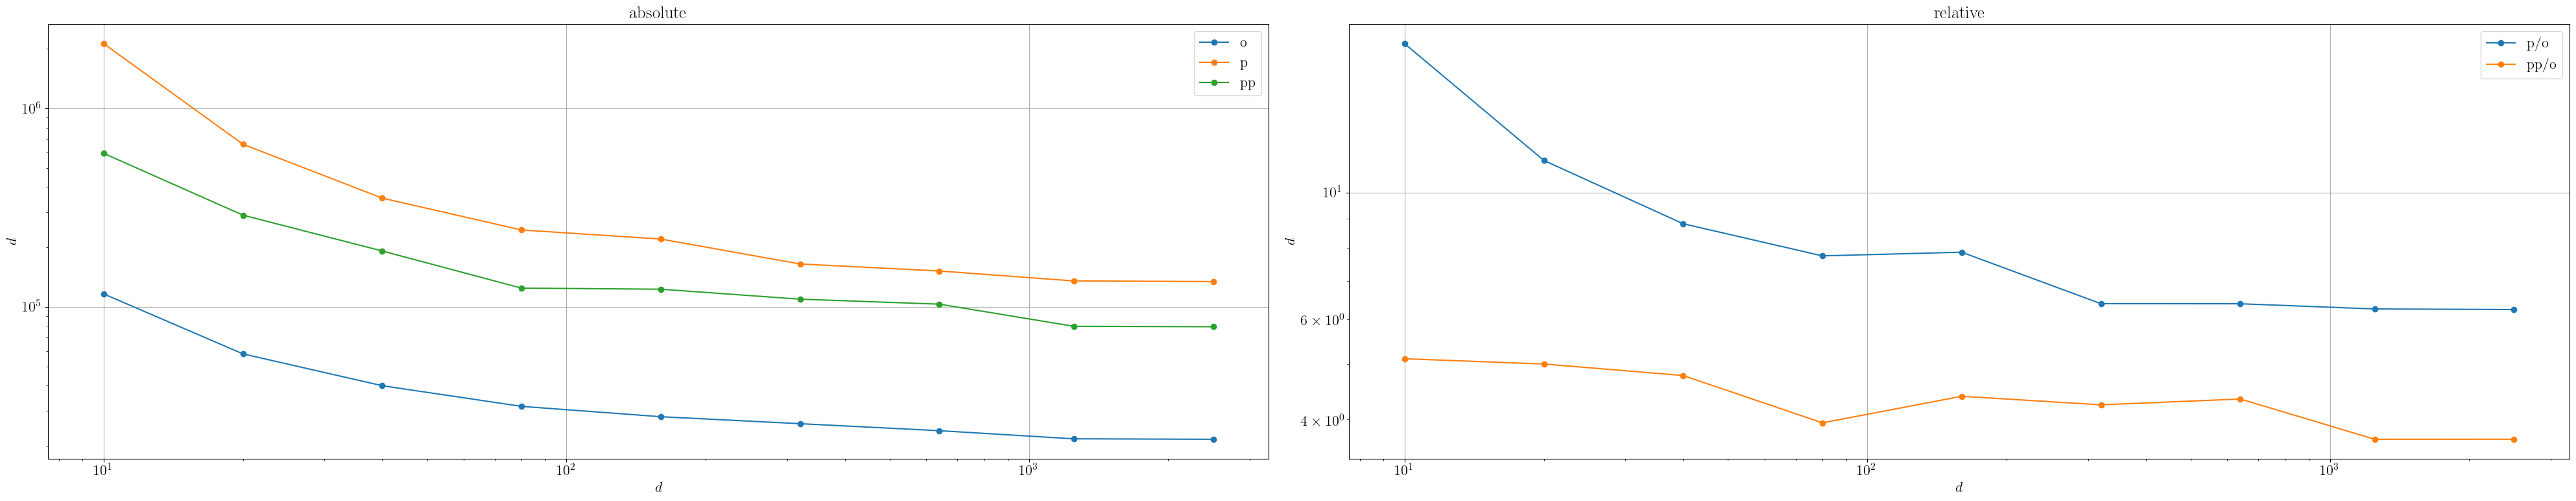

In [4]:
fig, axs = plt.subplots(1,2)
axs[0].loglog(d_list, results[:, 0], marker='o', label='o')
axs[0].loglog(d_list, results[:, 1], marker='o', label='p')
axs[0].loglog(d_list, results[:, 2], marker='o', label='pp')
axs[1].loglog(d_list, results[:, 1]/results[:, 0], marker='o', label='p/o')
axs[1].loglog(d_list, results[:, 2]/results[:, 0], marker='o', label='pp/o')
for ax, title in zip(axs, ['absolute', 'relative', ]): ax.set_xlabel(r'$d$'); ax.set_ylabel(r'$d$'); ax.grid(); ax.set_title(title); ax.legend()
plt.tight_layout()

### In dependence of the size of the multi-index (keeping the dimension fixed at $d=200$)

In [5]:
n_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
results = np.zeros((len(n_list), 3))

d = 200
for i, n in enumerate(n_list) :
    k = [np.log((2+j)/np.log(2)) for j in range(d)]
    node_gen = nodes.Leja(dim=d)
    t = indices.find_suitable_t(k, n, nested=node_gen.is_nested)
    indxs = indices.indexset_sparse(k, t)
    results[i] = size_o(indxs, k, t, d), size_p(indxs, k, t, d), size_pp(indxs, k, t, d)

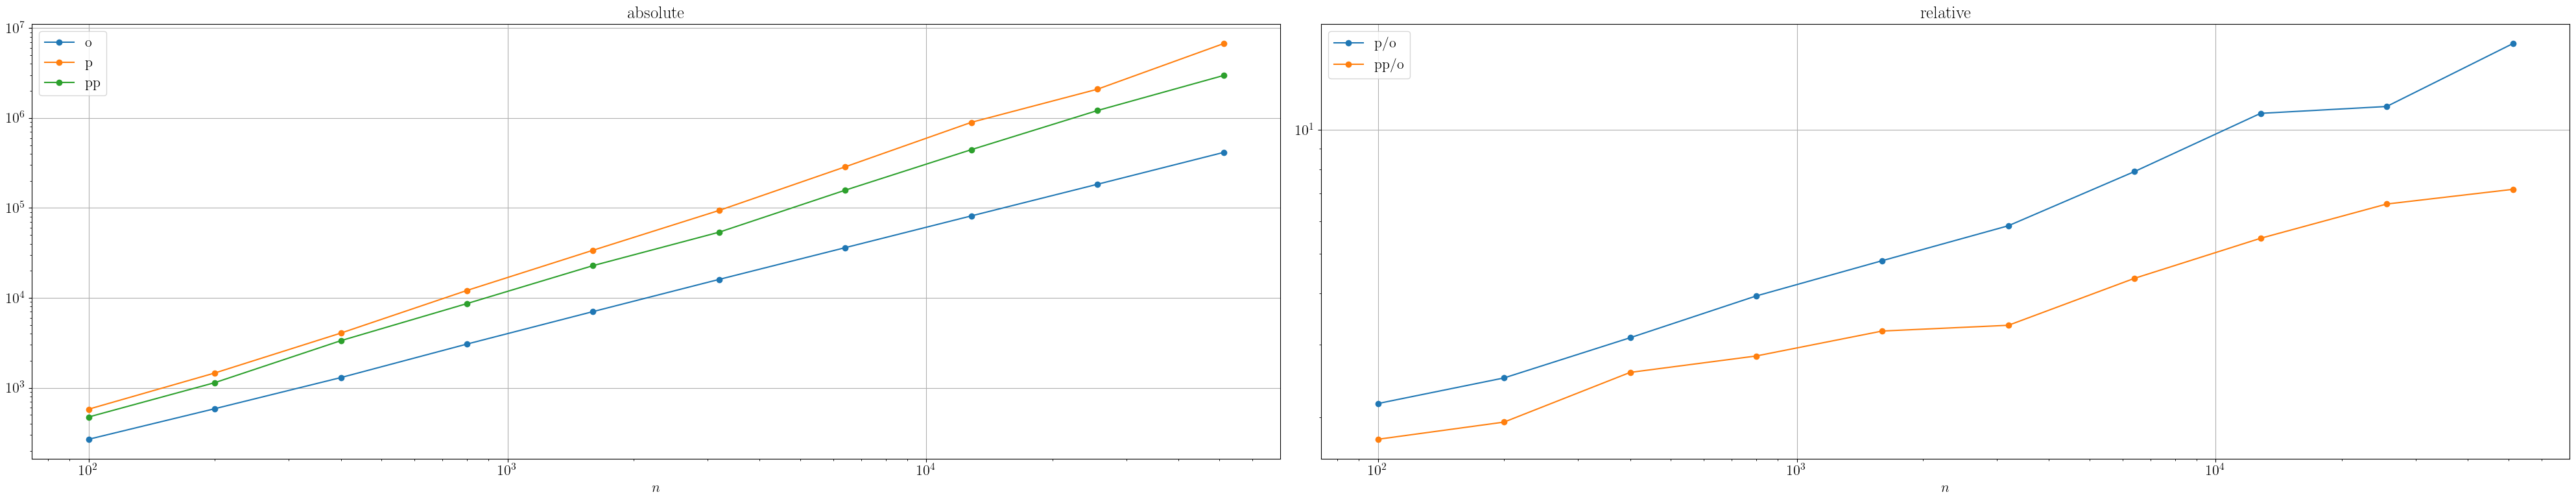

In [6]:
fig, axs = plt.subplots(1,2)
axs[0].loglog(n_list, results[:, 0], marker='o', label='o')
axs[0].loglog(n_list, results[:, 1], marker='o', label='p')
axs[0].loglog(n_list, results[:, 2], marker='o', label='pp')
axs[1].loglog(n_list, results[:, 1]/results[:, 0], marker='o', label='p/o')
axs[1].loglog(n_list, results[:, 2]/results[:, 0], marker='o', label='pp/o')
for ax, title in zip(axs, ['absolute', 'relative', ]): ax.set_xlabel(r'$n$'); ax.grid(); ax.set_title(title); ax.legend()
plt.tight_layout()